# Hybrid Demucs

Feel free to use the Colab version:
https://colab.research.google.com/drive/1dC9nVxk3V_VPjUADsnFu8EiT-xnU1tGH?usp=sharing

In [ ]:
#!pip install -U demucs
# or for local development, if you have a clone of Demucs
# pip install -e .

In [2]:
# You can use the `demucs` command line to separate tracks
!demucs song1/song1.wav


  0%|                                                                                 | 0.0/204.75 [00:00<?, ?seconds/s]
  3%|██                                                                      | 5.85/204.75 [00:07<04:15,  1.28s/seconds]
  6%|████                                                                    | 11.7/204.75 [00:15<04:07,  1.28s/seconds]
  9%|████▉                                                     | 17.549999999999997/204.75 [00:22<03:57,  1.27s/seconds]
 11%|████████▏                                                               | 23.4/204.75 [00:29<03:48,  1.26s/seconds]
 14%|██████████▏                                                            | 29.25/204.75 [00:36<03:39,  1.25s/seconds]
 17%|█████████▉                                                | 35.099999999999994/204.75 [00:44<03:31,  1.25s/seconds]
 20%|███████████▌                                              | 40.949999999999996/204.75 [00:51<03:23,  1.24s/seconds]
 23%|████████████████▍         

Important: the default model was recently changed to `htdemucs` the latest Hybrid Transformer Demucs model. In some cases, this model can actually perform worse than previous models. To get back the old default model use `-n mdx_extra_q`.
Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in C:\Users\arthv\Documents\GitHub\DeepLearning\demucs\separated\htdemucs
Separating track song1\song1.wav
Important: the default model was recently changed to `htdemucs` the latest Hybrid Transformer Demucs model. In some cases, this model can actually perform worse than previous models. To get back the old default model use `-n mdx_extra_q`.
Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in C:\Users\arthv\Documents\GitHub\DeepLearning\demucs\separated\htdemucs
Separating track song1\song1.wav



  0%|                                                                                 | 0.0/204.75 [00:00<?, ?seconds/s]
  3%|██                                                                      | 5.85/204.75 [00:10<06:08,  1.85s/seconds]
  6%|████                                                                    | 11.7/204.75 [00:20<05:44,  1.78s/seconds]
  9%|████▉                                                     | 17.549999999999997/204.75 [00:31<05:37,  1.81s/seconds]
 11%|████████▏                                                               | 23.4/204.75 [00:42<05:24,  1.79s/seconds]
 14%|██████████▏                                                            | 29.25/204.75 [00:52<05:13,  1.79s/seconds]
 17%|█████████▉                                                | 35.099999999999994/204.75 [01:02<05:00,  1.77s/seconds]
 20%|███████████▌                                              | 40.949999999999996/204.75 [01:14<04:59,  1.83s/seconds]
 23%|████████████████▍         

In [3]:
# You can also load directly the pretrained models,
# for instance for the MDX 2021 winning model of Track A:
from demucs import pretrained
model = pretrained.get_model('mdx')


In [4]:
import torch

def numel(m: torch.nn.Module, only_trainable: bool = False):
    assert isinstance(m, torch.nn.Module), f"{type(m)} is not a nn.Module"
    parameters = list(m.parameters())
    if only_trainable:
        parameters = [p for p in parameters if p.requires_grad]
    unique = {p.data_ptr(): p for p in parameters}.values()
    return sum(p.numel() for p in unique)

for i in range(4):
    print(f"Number of parameters {numel(model.models[i])}")

Number of parameters 88984040
Number of parameters 88984040
Number of parameters 83607872
Number of parameters 83884248


(8843231, 2)


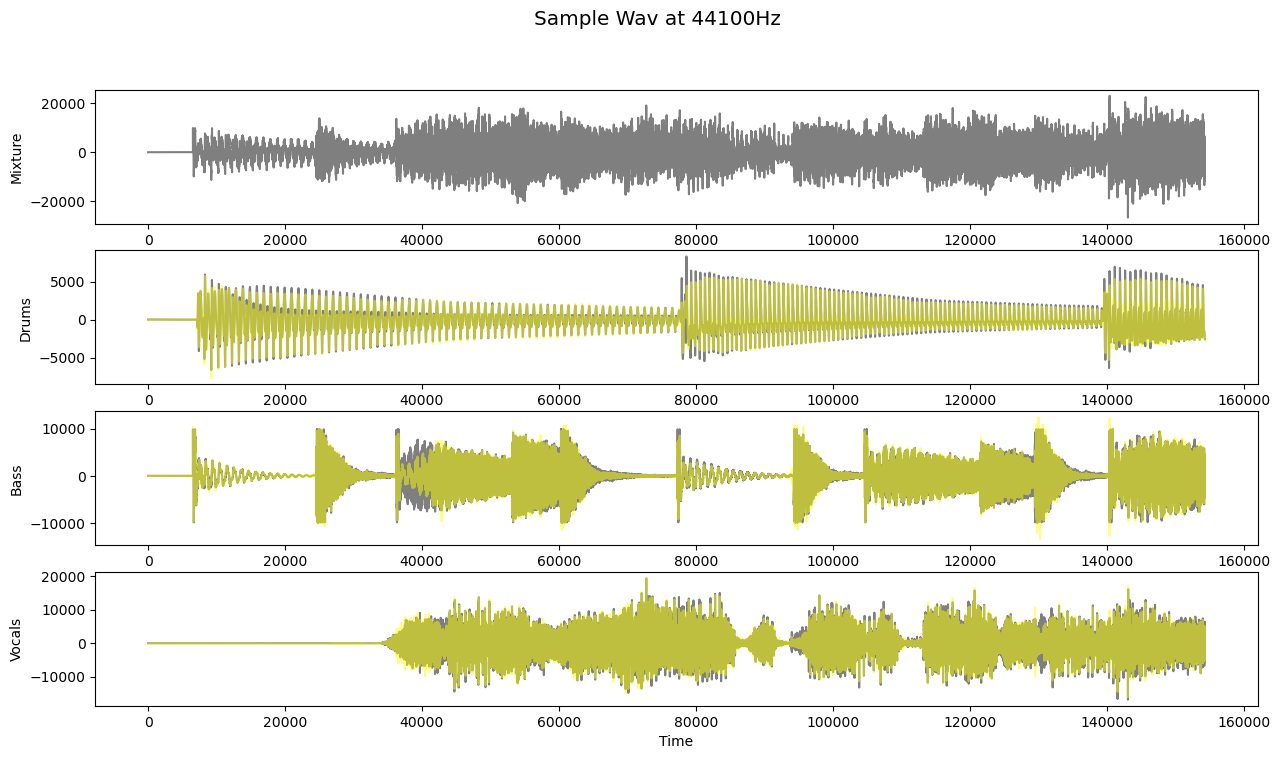

In [13]:
from scipy.io import wavfile
import matplotlib.pyplot as plt

samplerate, mix = wavfile.read('./song1/song1.wav')
_, drums = wavfile.read('./song1/drums.wav')
_, bass = wavfile.read('./song1/bass.wav')
_, vocals = wavfile.read('./song1/vocals.wav')

_, dmxd_drums = wavfile.read('./separated/htdemucs/song1/drums.wav')
_, dmxd_bass = wavfile.read('./separated/htdemucs/song1/bass.wav')
_, dmxd_vocals = wavfile.read('./separated/htdemucs/song1/vocals.wav')

label = ["Mixture", "Drums", "Bass", "Vocals"]
print(mix.shape)

# plot the first 1024 samples
fig, ax = plt.subplots(figsize=(15,8), nrows=4)

plt.xlabel("Time")
fig.suptitle(f"Sample Wav at {samplerate}Hz", fontsize="x-large")
ax[0].plot(mix[int(1.5*44100):5*44100, 0], color="black", alpha=0.5)
ax[1].plot(bass[int(1.5*44100):5*44100, 0], color="black", alpha=0.5)
ax[1].plot(dmxd_bass[int(1.5*44100):5*44100, 0], color="yellow", alpha=0.5)
ax[2].plot(drums[int(1.5*44100):5*44100, 0], color="black", alpha=0.5)
ax[2].plot(dmxd_drums[int(1.5*44100):5*44100, 0], color="yellow", alpha=0.5)
ax[3].plot(vocals[int(1.5*44100):5*44100, 0], color="black", alpha=0.5)
ax[3].plot(dmxd_vocals[int(1.5*44100):5*44100, 0], color="yellow", alpha=0.5)
for i, axe in enumerate(ax):
    axe.set_ylabel(label[i])
plt.show()

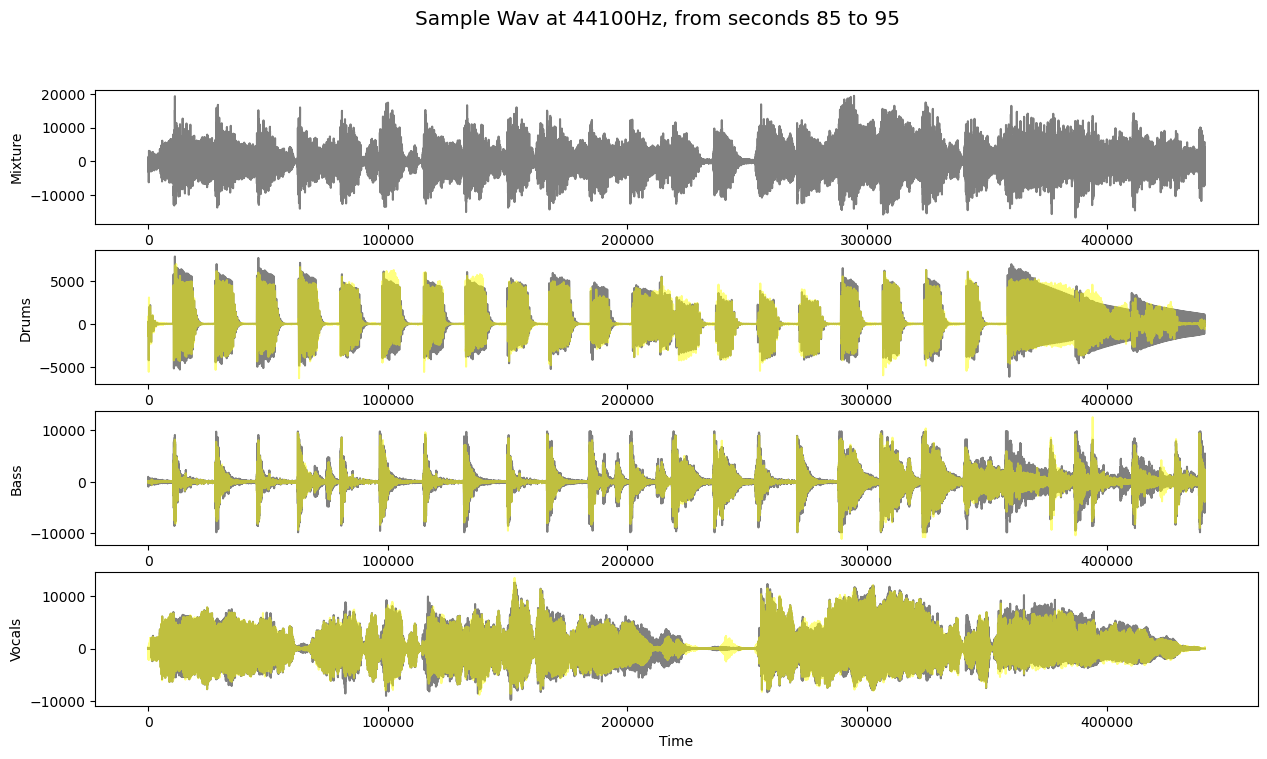

In [12]:
# Because `model` is a bag of 4 models, you cannot directly call it on your data,
# but the `apply_model` will know what to do of it.
import torch
from demucs.apply import apply_model
import numpy as np 
x = torch.randn(1, 2, 44100 * 10)  # ten seconds of white noise for the demo

sec = np.random.randint(0,100)
samplerate, mix = wavfile.read('./song1/song1.wav')
_, drums = wavfile.read('./song1/drums.wav')
_, bass = wavfile.read('./song1/bass.wav')
_, vocals = wavfile.read('./song1/vocals.wav')


label = ["Mixture", "Drums", "Bass", "Vocals"]


mix_t = torch.tensor(mix[sec * 44100:(sec + 10) * 44100, 0], dtype=torch.float32)
mix_t = torch.stack([mix_t, mix_t]).unsqueeze(0)

with torch.no_grad():
    out = apply_model(model, mix_t)[0]

fig, ax = plt.subplots(figsize=(15,8), nrows=4)

plt.xlabel("Time")
fig.suptitle(f"Sample Wav at {samplerate}Hz, from seconds {sec} to {sec+10}", fontsize="x-large")
ax[0].plot(mix[sec * 44100:(sec + 10) * 44100, 0], color="black", alpha=0.5)
ax[1].plot(bass[sec * 44100:(sec + 10) * 44100, 0], color="black", alpha=0.5)
ax[1].plot(out[1, 0, :], color="yellow", alpha=0.5)
ax[2].plot(drums[sec * 44100:(sec + 10) * 44100, 0], color="black", alpha=0.5)
ax[2].plot(out[0, 0, :], color="yellow", alpha=0.5)
ax[3].plot(vocals[sec * 44100:(sec + 10) * 44100, 0], color="black", alpha=0.5)
ax[3].plot(out[3, 0, :], color="yellow", alpha=0.5)
for i, axe in enumerate(ax):
    axe.set_ylabel(label[i])
plt.show()


In [ ]:
# For training or more fun, refer to the Demucs README on our repo
# https://github.com/facebookresearch/demucs/tree/main/demucs